<a href="https://colab.research.google.com/github/Mhammad-riyaz/Multi-Attention-Transformer/blob/main/nano_gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-10-20 13:25:21--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2025-10-20 13:25:21 (30.5 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
with open('input.txt', 'r', encoding='utf-8') as f:
  text = f.read()

In [ ]:
len(text)

1115394

In [ ]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [ ]:
# now lets build the encoder and decoder that represents our text in some numericals

stoi = {ch : i for i,ch in enumerate(chars)}
itos = {i : ch for i,ch in enumerate(chars)}
encode = lambda s : [stoi[c] for c in s] # take a string and output a list of integers
decode = lambda l : ''.join([itos[c] for c in l]) # take a list of integers and output a string

print(encode("hi there"))
print(decode(encode("hi there")))


[46, 47, 1, 58, 46, 43, 56, 43]
hi there


In [ ]:
# there is a library for tokenization called tiktoken used by openai for gpt before, the vocabulary size is 50257, instead of characters
# it will be broke down the words in tokens. But for now we are using a simple character level tokenizer.

In [ ]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text),dtype=torch.long)
print(data.shape,data.type)
print(data[:1000])


torch.Size([1115394]) <built-in method type of Tensor object at 0x7a66f1c08a50>
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 

In [ ]:
# now lets split our dataset to train and validation sets
n = int(0.9*len(data)) # 90% for training and 10% for validation
train_data = data[:n]
val_data = data[n:]



In [ ]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [ ]:
# the reason we are added +1 to block_size instead of 8 is to make sure to have 8 examples that is,
# from the output we can see after 18, 47 comes next, after 18 47, 56 comes next, after 18 47 56, 58 comes next and so on 8 examples.

In [ ]:
x = train_data[:block_size] # these are inputs to the transformer
y = train_data[1:block_size+1] # these are the targets for each position in x (input) i.e the next likely character.

for t in range(block_size):
  context = x[:t+1]
  target = y[t]
  print(f'when input is {context} the target : {target}')

when input is tensor([18]) the target : 47
when input is tensor([18, 47]) the target : 56
when input is tensor([18, 47, 56]) the target : 57
when input is tensor([18, 47, 56, 57]) the target : 58
when input is tensor([18, 47, 56, 57, 58]) the target : 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target : 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target : 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target : 58


In [ ]:
# we are not only training in this manner of sequences for efficiency but also to make the Transformer network be used to seeing contexts
# all the way from as little as one to all the way of the block size. So basically we would like the transformer to see everything
# in between, this going to be useful later in the inference, because while we are sampling, we can start sampling generation as little
# as one character context and then can start buliding upto the block size, after reaching the block size we have to start truncating
# because the transformer will never able to receive inputs that are more than the block size.

In [ ]:
# we took an example above of single batch, generally we will be training will multiple batches of these examples, so the batch will
# be our other dimmension. This is done for efficiency because the GPUs are good at parallel processing of data.

In [ ]:
torch.manual_seed(1337)
batch_size = 4 # independent sequences which will be processed parallelly
block_size = 8 # maximum context lenght for predictions

def get_batch(split):
  data = train_data if split == "train" else val_data
  ix = torch.randint(len(data)-block_size,(batch_size,)) # generating random offsets
  x = torch.stack([data[i:i+block_size] for i in ix]) # generating the inputs
  y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # generating the corresponding next sequences (targets)
  return x,y

xb,yb = get_batch("train")
print("inputs:")
print(xb.shape)
print(xb)
print("targets:")
print(yb.shape)
print(yb)

for b in range(batch_size):
  for t in range(block_size):
    context = xb[b, :t+1]
    target = yb[b,t]
    print(f'when input is {context} the target : {target}')

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
when input is tensor([24]) the target : 43
when input is tensor([24, 43]) the target : 58
when input is tensor([24, 43, 58]) the target : 5
when input is tensor([24, 43, 58,  5]) the target : 57
when input is tensor([24, 43, 58,  5, 57]) the target : 1
when input is tensor([24, 43, 58,  5, 57,  1]) the target : 46
when input is tensor([24, 43, 58,  5, 57,  1, 46]) the target : 43
when input is tensor([24, 43, 58,  5, 57,  1, 46, 43]) the target : 39
when input is tensor([44]) the target : 53
when input is tensor([44, 53]) the target : 56
when input is tensor([44, 53, 56]) the target : 1
when input is

In [ ]:

# Lets implement a bigram now using torch.nn

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed   (1337)

class BigramLanguageModel(nn.Module):

  def __init__ (self,vocab_size):
    super().__init__()
    # each token directly reads off the logits for the next token from the below lookup table ex : 24 will look at the 24 the row just
    # like in the bigram we implemented before
    self.token_embedding_table = nn.Embedding(vocab_size,vocab_size)

  def forward(self, idx ,targets=None):

    # idx and targets are both (B,T) tensor of integers
    logits = self.token_embedding_table(idx) # (B,T,C) B=batch_size=4 T=Time=8(context) C=channels=vocab_size

    # the below won't work because the pytorch expects the inputs as (B*T,C) and targets as (B*T)
    # loss = F.cross_entropy(logits,targets)
    if targets == None :
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits,targets)
    return logits,loss

  def generate(self,idx,max_new_tokens):
    # idx is (B,T) array of indices
    for _ in range(max_new_tokens):
      # get the predictions
      logits,loss = self(idx)
      # focus only on the last time step that's why -1, because out next sequences will be there only
      logits = logits[:,-1, :] # becomes (B,C)
      # apply softmax to get the probabilities
      probs = F.softmax(logits, dim=-1) # (B,C)
      # sample from the distribution
      idx_next = torch.multinomial(probs,num_samples=1) # (B,1)
      # append sampled index to the running sequence
      idx = torch.cat((idx,idx_next),dim=1) # (B,T+1)
    return idx

m = BigramLanguageModel(vocab_size)
logits,loss = m(xb,yb)
print(logits.shape)
print(loss)

idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx,max_new_tokens=100)[0].tolist())) # the indexing with 0 is because the generate works with batches for this the batch is one only



torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


In [ ]:
# creating an optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
# This way of evaluation is pretty accurate

eval_iters = 200
eval_interval = 300

@torch.no_grad()
def estimate_loss():
  out = {}
  m.eval()
  for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, Y = get_batch(split)
      logts, loss = m(X,Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  m.train()
  return out


In [ ]:
batch_size = 32 # increasing the batch size
for iter in range(10000):


  # every once in a while evaluate the loss on train and val sets
  if iter % eval_interval == 0 :
    losses = estimate_loss()
    print(f'step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}')

  # sample a batch of data
  xb,yb = get_batch("train")

  # evaluate the loss
  logits, loss = m(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

# print(loss.item())


step 0: train loss 4.7296, val loss 4.7235
step 300: train loss 4.3767, val loss 4.3844
step 600: train loss 4.0784, val loss 4.0838
step 900: train loss 3.8092, val loss 3.8103
step 1200: train loss 3.5729, val loss 3.5832
step 1500: train loss 3.3816, val loss 3.3900
step 1800: train loss 3.2193, val loss 3.2273
step 2100: train loss 3.0785, val loss 3.0809
step 2400: train loss 2.9584, val loss 2.9731
step 2700: train loss 2.8726, val loss 2.8846
step 3000: train loss 2.7959, val loss 2.8045
step 3300: train loss 2.7426, val loss 2.7433
step 3600: train loss 2.6890, val loss 2.7012
step 3900: train loss 2.6533, val loss 2.6584
step 4200: train loss 2.6169, val loss 2.6289
step 4500: train loss 2.6066, val loss 2.6003
step 4800: train loss 2.5727, val loss 2.5888
step 5100: train loss 2.5594, val loss 2.5539
step 5400: train loss 2.5311, val loss 2.5491
step 5700: train loss 2.5293, val loss 2.5324
step 6000: train loss 2.5165, val loss 2.5252
step 6300: train loss 2.5102, val loss 2

In [ ]:
idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx,max_new_tokens=300)[0].tolist()))


Thif KIOLERAUS tiey hanentherve s h trat w.
Ane s al ifre t, nd doororounond pugCO:
gh ng t?
DUTh, ICot-wh:
The mealakemas f the isus waclom,
MESir, h tll f hou heale bane, wheshild'the inturntheiENorirowor ne re pr oras, h,
Twin fl co ast pes!
TOKIf, blde d serJ?'s, congryontermer CENAsqut INGHN th


In [ ]:
# much better but not shakeshpeare ofcourse

# by far we are just looking the current character and predicting the next token or character we are not looking in the history at all.

# The Mathematical text in Self Attention

In [ ]:
# consider the following example
torch.manual_seed(1337)
B, T, C = 4,8,2
x = torch.randn(B,T,C)
x.shape
# so far we are only using the current token, but we somehow need to make sure that all the tokens are communicating with others inorder
# to achieve attention but for example a token at 5th postion should only need to communicate with 4,3,2,1 but not with 6,7 etc
# because these are the future token.

# One thing we can do here is to take the mean of all the previous tokens and present it as a feature for the current token, but taking
# the average is very simple and lossy way of communication/interaction because we are losing so much data.
# But lets implement this.

torch.Size([4, 8, 2])

In [ ]:
xbow = torch.zeros((B,T,C))
for b in range(B):
  for t in range(T):
    xprev = x[b,:t+1] # from the b storing all the previous t's (context) including the current ---> (t,C)
    # basically we are storing all the past and current tokens and their corresponding probabilites of next word in channels
    xbow[b,t] = torch.mean(xprev,0) # mean along the context or tokens




In [ ]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [ ]:
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

In [ ]:
# basically what we are doing here is to get xbow[0][0] we are averaging x[0][0] (its the first one)
# to get xbow[0][1] we are averageing x[0][0] and x[0][1]
# to get xbow[0][2] we are averageing x[0][0] and x[0][1] and x[0][2]
# to get xbow[0][3] we are averageing x[0][0] and x[0][1] and x[0][2]  and x[0][3] and so on

# But what we are doing about is very inefficient and the trick we mentioned above comes with matix mulitplication

In [ ]:
# lets take an example

torch.manual_seed(42)
a = torch.ones(3, 3)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

# so matrix multiplication is basically dot product of the first row of 'a' and first column of 'b', which gives us c[0,0], so on.
print('---')
print(torch.tril(torch.ones(3,3))) # tril gives us a lower traingular matrix
# so now if we apply this to a
print('---')

a = torch.tril(torch.ones(3, 3))
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

# what we can observe from this is, for the first row of 'a' a[0,0]=1 so it only got the first col's value of b[0,0] in c[0,0].
# for the second row there are two ones so it uses two values from the b's columns to get the result and the remaining will be 0 (off)

# so basically for the first row in 'a' we are just plucking out b[0]
# and for the second row in 'a' we are adding  b[0] and b[1]
# and for the third row in 'a' we are adding b[0] and b[1] and b[2]

# basically we are doing the same thing as above while taking the averages of previous context/tokens.
# but here we are just doing the sums, to get the averages we can simply average the a matrix

a = a/torch.sum(a,1,keepdim=True)
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

# now the first row of c is the average of b[0] of b (same as b)
# now the second row of c is the average of b[0] and b[1]
# now the third row of c is the average of b[0] and b[1] and b[2]


a=
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])
---
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
---
a=
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])
a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [ ]:
# Now let's go back to the previous example
wei = torch.tril(torch.ones(T,T))
wei  = wei/wei.sum(1,keepdim=True)
xbow2 = wei @ x # (T,T)  @ (B,T,C) pytorch will notice that the dimensions are not same so pytorch broadcasts (T,T) -> (B,T,T) => (B,T,T) @ (B,T,C)
torch.allclose(xbow,xbow2)
# for some reason we are getting false but the values are the same

False

In [ ]:
# another version

tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0,float('-inf')) # this will make the wei as infinity at the indices where the tril values are 0 (upper traingular part)
wei = F.softmax(wei,dim=-1) # gives us the same average/mean as above
xbow3 = wei @ x
torch.allclose(xbow,xbow3)

# again for some reason getting False but the values are same


# The reason why we use this approach is the wei(weights) start as 0s, this wei acts some kind of strength or affinity which tells us
# that strength or the communication part like in the next masking step we are filling out all the future context/tokens as infinity
# saying that it cannot communicate with the future tokens.

# one thing to note here is the wei starts as all 0s but it wont be the case, they are going to be data dependent, these tokens start
# looking at each other some tokens find other tokens less/more interesting depending upon their values.

False

In [ ]:
# minor code changes

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
n_embd = 32
block_size=8

class BigramLanguageModel(nn.Module):

  def __init__ (self): # vocab_size is already defined
    super().__init__()

    self.token_embedding_table = nn.Embedding(vocab_size,n_embd) # changing from vocab_size to n_embd because we are now getting the logits
    # directly but to expand it to pass through the intermediate stage, adding or specifying the number of dimmensions.
    # this wont gives logits but gives us token embedings to get the logits we need to add a linear layer
    self.lm_head = nn.Linear(n_embd, vocab_size) #  --> linear layer

    # Another thing is what people do is not only embed the input tokens but also their postions.
    self.position_embedding_table = nn.Embedding(block_size,n_embd) # block_size because the inputs will of that size only



  def forward(self, idx ,targets=None):

    B,T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    token_emb = self.token_embedding_table(idx) # now we wont be getting logists anymore here -> (B,T,n_embd)
    pos_emb = self.position_embedding_table(torch.arange(T)) # (T,n_embd)
    x = token_emb + pos_emb # (B,T,n_embd) + (T,n_embd) work fine because of broadcasting
    logits = self.lm_head(x) # (B,T,vocab_size)

     # adding the postion block won't matter much because its just a bigram model but eventually when we add the self attention it will help

    if targets == None :
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits,targets)
    return logits,loss

  def generate(self,idx,max_new_tokens):
    for i in range(max_new_tokens):
      # crop idx to the last block_size tokens
      idx_cond = idx[:, -block_size:]
      # get the predictions
      logits, loss = self(idx_cond)
      # the reason to add this idx_cond is now we can only take the block_size context only bc we added the postitional embedding
      # of size of (block_size, n_embd), so it will run out of scope.
      logits = logits[:,-1, :]
      probs = F.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,idx_next),dim=1)
    return idx

m = BigramLanguageModel()
logits,loss = m(xb,yb)
print(logits.shape)
print(loss)

idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx,max_new_tokens=100)[0].tolist()))

torch.Size([256, 65])
tensor(4.4780, grad_fn=<NllLossBackward0>)

SqWdIgmOVWycZ3'B;hKOQ
aOGGPPciu&U
BhItCZ'qPbXMrtqWrNlbZO&GlV&qcoh'NYYQeQzrmiixwcNQgAo3EPN hOYK!tqzrE


In [ ]:

# Crux of self attention with one head

# As we mentioned previously we don't want the wei to be unifrom (all equal to zero), different tokens find
# different tokens interesting and we want that to be data dependent
# Ex: IF a token is vowel, it maybe lookint at all the previous consonants in the past.

# So basically we want to gather the i nformation from the past but we want that in a data dependent way and this is the problem that
# self attention solves.

# The way it solves is the following :
# Each single token/node at each position will emit two vectors
# 1) Query => It tells "What I am looking for?"
# 2) Key => It tells "What do I contain?"

# Now the way, we get the afinities is by doing the dot product between the keys and queries => the current node/token's query dot products
# with all the keys of all the other tokens and it becomes our wei.
# If the current node's query and another token's key are sort of aligned, then it gets to learn more about that token when compared to
# other tokens/nodes. Basically the dot product will yeild in a higher value.

# Instead of aggregating (mean) of the raw x, we add one more layer called value. we can think of this like 'x' as some kind of private
# information to a token.

torch.manual_seed(1337)
B, T, C = 4,8,32 # changing it to 32 from 2
x = torch.randn(B,T,C)
x.shape

# Self attentions with Single Head

head_size = 16            # ---> a hyper parameter
key = nn.Linear(C,head_size,bias=False)
query = nn.Linear(C,head_size,bias=False)
value = nn.Linear(C,head_size,bias=False)

# now lets forward the x through these
k = key(x) # --> (B,T,16)
q = key(x) # --> (B,T,16)

# when we forward through x, then all the postion of B,T in parallel, independently produce a key and a query but no communication yet.

wei = q @ k.transpose(-2,-1) # (B, T ,16) @ (B ,16 ,T ) --> (B, T, T)


tril = torch.tril(torch.ones(T,T))
# wei = torch.zeros((T,T))

wei = wei.masked_fill(tril==0,float('-inf'))
wei = F.softmax(wei,dim=-1)
v = value(x)
out = wei @ v # <----- v instead of x
out.shape


torch.Size([4, 8, 16])

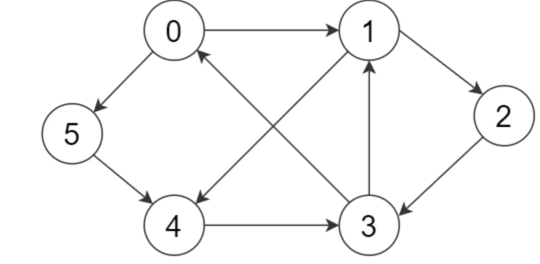

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. These nodes don't have any idea where they are positioned in the space. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate, used in sentiment analysis. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [ ]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)

wei = q @ k.transpose(-2,-1)
print(k.var())
print(q.var())
print(wei.var())

# As we can see that the wei's variance is on the order of head size

wei =  q @ k.transpose(-2,-1) * head_size ** -0.5
print(wei.var())

# Now the varaince is one, it is preserved.
# The reason to normalize with square root of head_size is if there are any extremely larger values or smaller values in wei, and we are
# applying softmax on it, it will converge towards one hot vectors.


tensor(1.0449)
tensor(1.0700)
tensor(17.4690)
tensor(1.0918)


In [ ]:
torch.softmax(torch.tensor([0.1,-0.2,0.3,-0.2,0.5]), dim=-1)

# Here when we apply the softmax to values that are closer to zero, then we are going to get the diffused values/spread out values
# out of softmax, not too sharp or not too flat.

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [ ]:
torch.softmax(torch.tensor([0.1,-0.2,0.3,-0.2,0.5])*8, dim=-1)

# Here softmax is very peaky — almost all weight goes to one value (0.5 becomes dominant), in this case only the information from this node
# will be aggregated, so that's why we want atleast during the intialization that the softmax is spread out.

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [ ]:
class Head(nn.Module):
  """ one head of self attention """

  def __init__ (self,head_size):
    super().__init__()
    self.key = nn.Linear(n_embd,head_size,bias=False)
    self.query = nn.Linear(n_embd,head_size,bias=False)
    self.value = nn.Linear(n_embd,head_size,bias=False)
    self.register_buffer("tril",torch.tril(torch.ones(block_size, block_size)))

  def forward(self, x):
    B,T,C = x.shape
    k = self.key(x) # B,T,C
    q = self.query(x) # B,T,C
    # compute attention scores (affinitiess)
    wei = q  @ k.transpose(-2,-1) * (head_size**-0.5)  # B,T,C @ B,T,C => B,T,T
    wei = wei.masked_fill(self.tril[:T,:T] ==0, float('-inf')) # B,T,T
    wei = F.softmax(wei, dim=-1) # B,T,T
    # perform the weighted aggregation of the vallues
    v = self.value(x) # B,T,C
    out = wei @ v # (B,T,T) @ (B,T,C) = (B,T,T)
    return out




In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
n_embd = 32
block_size=8

class BigramLanguageModel(nn.Module):

  def __init__ (self): # vocab_size is already defined
    super().__init__()

    self.token_embedding_table = nn.Embedding(vocab_size,n_embd) # changing from vocab_size to n_embd because we are now getting the logits
    # directly but to expand it to pass through the intermediate stage, adding or specifying the number of dimmensions.
    # this wont gives logits but gives us token embedings to get the logits we need to add a linear layer
    self.lm_head = nn.Linear(n_embd, vocab_size) #  --> linear layer

    # Another thing is what people do is not only embed the input tokens but also their postions.
    self.position_embedding_table = nn.Embedding(block_size,n_embd) # block_size because the inputs will of that size only
    self.sa_head = Head(n_embd) # self attention layer


  def forward(self, idx ,targets=None):

    B,T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    token_emb = self.token_embedding_table(idx) # now we wont be getting logists anymore here -> (B,T,n_embd)
    pos_emb = self.position_embedding_table(torch.arange(T)) # (T,n_embd)
    x = token_emb + pos_emb # (B,T,n_embd) + (T,n_embd) work fine because of broadcasting
    x = self.sa_head(x) # applying one head of self attention
    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets == None :
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits,targets)
    return logits,loss

  def generate(self,idx,max_new_tokens):
    for _ in range(max_new_tokens):
      # get the predictions
      idx_cond = idx[:,-block_size:]
      logits, loss = self(idx_cond)
      logits = logits[:,-1, :]
      probs = F.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,idx_next),dim=1)
    return idx

m = BigramLanguageModel()
logits,loss = m(xb,yb)
print(logits.shape)
print(loss)

idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx,max_new_tokens=100)[0].tolist()))

torch.Size([256, 65])
tensor(4.1703, grad_fn=<NllLossBackward0>)

eefnrXLFs?Z,gfrx.dB$bRFwEun U3pqPej3Pt-y?'lwrWl!$V-:I,kwGR$&m?cNlMN'w:NtErKcfjmKZvFDGvpzNweVogZPQRs,


In [ ]:
# Note that the self attention won't tolerate high learning rate
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:

max_iters = 10000
batch_size = 32
eval_interval = 500

for iter in range(max_iters):


  # every once in a while evaluate the loss on train and val sets
  if iter % eval_interval == 0 :
    losses = estimate_loss()
    print(f'step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}')

  # sample a batch of data
  xb,yb = get_batch("train")

  # evaluate the loss
  logits, loss = m(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

# print(loss.item())


step 0: train loss 4.2089, val loss 4.2084
step 500: train loss 2.7150, val loss 2.7317
step 1000: train loss 2.5561, val loss 2.5464
step 1500: train loss 2.4768, val loss 2.4882
step 2000: train loss 2.4425, val loss 2.4626
step 2500: train loss 2.4323, val loss 2.4347
step 3000: train loss 2.4087, val loss 2.4385
step 3500: train loss 2.4146, val loss 2.4286
step 4000: train loss 2.4074, val loss 2.4122
step 4500: train loss 2.4033, val loss 2.4083
step 5000: train loss 2.3903, val loss 2.4108
step 5500: train loss 2.3901, val loss 2.4076
step 6000: train loss 2.3751, val loss 2.4011
step 6500: train loss 2.3714, val loss 2.3898
step 7000: train loss 2.3688, val loss 2.3971
step 7500: train loss 2.3768, val loss 2.3780
step 8000: train loss 2.3664, val loss 2.3846
step 8500: train loss 2.3663, val loss 2.3875
step 9000: train loss 2.3499, val loss 2.3888
step 9500: train loss 2.3545, val loss 2.3918


In [ ]:
estimate_loss()
# we have gone from 2.4 to 2.3 of loss

{'train': tensor(2.3492), 'val': tensor(2.3809)}

In [ ]:
idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx,max_new_tokens=100)[0].tolist()))


Th
UENMI:
S:
E ENTING LAUnged betve.

G LANDe! ig you the hour, chee,
Asun oll.

INFRoue chat; tho f


In [ ]:
# we have implemented the scaled Dot-product Attention (refer the self attention paper), now we are going to implement the
#   Multi Head Attention

# Multi Head Attention is just applying multiple attentions in parallel and concatenating the results

In [ ]:
class MultiHeadAttention(nn.Module):
  """ Multiple heads of self-attention in parallel """

  def __init__(self, num_heads,head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

  def forward(self, x):
    return torch.cat([h(x) for h in self.heads], dim=-1)

  # we are simply creating the num_heads size of heads of head_size and concatenating their output accross the channels.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
n_embd = 32
block_size=8

class BigramLanguageModel(nn.Module):

  def __init__ (self): # vocab_size is already defined
    super().__init__()

    self.token_embedding_table = nn.Embedding(vocab_size,n_embd) # changing from vocab_size to n_embd because we are now getting the logits
    # directly but to expand it to pass through the intermediate stage, adding or specifying the number of dimmensions.
    # this wont gives logits but gives us token embedings to get the logits we need to add a linear layer
    self.lm_head = nn.Linear(n_embd, vocab_size) #  --> linear layer

    # Another thing is what people do is not only embed the input tokens but also their postions.
    self.position_embedding_table = nn.Embedding(block_size,n_embd) # block_size because the inputs will of that size only
    # self.sa_head = Head(n_embd)
    self.sa_heads = MultiHeadAttention(4,n_embd//4) # 4 heads of 8-dimensional self attention


  def forward(self, idx ,targets=None):

    B,T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    token_emb = self.token_embedding_table(idx) # now we wont be getting logists anymore here -> (B,T,n_embd)
    pos_emb = self.position_embedding_table(torch.arange(T)) # (T,n_embd)
    x = token_emb + pos_emb # (B,T,n_embd) + (T,n_embd) work fine because of broadcasting
    x = self.sa_heads(x) # applying one head of self attention (B,T,n_embd)
    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets == None :
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits,targets)
    return logits,loss

  def generate(self,idx,max_new_tokens):
    for _ in range(max_new_tokens):
      # get the predictions
      idx_cond = idx[:,-block_size:]
      logits, loss = self(idx_cond)
      logits = logits[:,-1, :]
      probs = F.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,idx_next),dim=1)
    return idx

m = BigramLanguageModel()
logits,loss = m(xb,yb)
print(logits.shape)
print(loss)

idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx,max_new_tokens=100)[0].tolist()))

torch.Size([256, 65])
tensor(4.1795, grad_fn=<NllLossBackward0>)

eefnnXLFs?Z,gfrx.dB$tRFwEun U3pqPej3Pt-y?'SwrWl!$K-:I,IwIR$&,?cnlMv'w:NtErKcfjmKZvFDGvpzx?eVoHZPQJP,


In [ ]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:

max_iters = 10000
batch_size = 32
eval_interval = 500

for iter in range(max_iters):


  # every once in a while evaluate the loss on train and val sets
  if iter % eval_interval == 0 :
    losses = estimate_loss()
    print(f'step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}')

  # sample a batch of data
  xb,yb = get_batch("train")

  # evaluate the loss
  logits, loss = m(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

# print(loss.item())


step 0: train loss 4.1760, val loss 4.1767
step 500: train loss 2.6692, val loss 2.6816
step 1000: train loss 2.4968, val loss 2.4845
step 1500: train loss 2.4030, val loss 2.4200
step 2000: train loss 2.3578, val loss 2.3801
step 2500: train loss 2.3380, val loss 2.3405
step 3000: train loss 2.2997, val loss 2.3343
step 3500: train loss 2.2980, val loss 2.3196
step 4000: train loss 2.2812, val loss 2.2979
step 4500: train loss 2.2678, val loss 2.2814
step 5000: train loss 2.2522, val loss 2.2807
step 5500: train loss 2.2423, val loss 2.2731
step 6000: train loss 2.2188, val loss 2.2613
step 6500: train loss 2.2177, val loss 2.2477
step 7000: train loss 2.2114, val loss 2.2549
step 7500: train loss 2.2128, val loss 2.2339
step 8000: train loss 2.1965, val loss 2.2413
step 8500: train loss 2.1943, val loss 2.2383
step 9000: train loss 2.1719, val loss 2.2405
step 9500: train loss 2.1801, val loss 2.2386


In [ ]:
estimate_loss()
# we have gone from 2.3 to 2.2 of validation loss, we can see that the validation loss is improving, so the multiple communication channels
# help because these tokens have sort of lot to talk about, they want to find the consonants, the vowels. So the multiple independent
# channels of communication helps a lot to gather lots of different types of data.

{'train': tensor(2.1678), 'val': tensor(2.2327)}

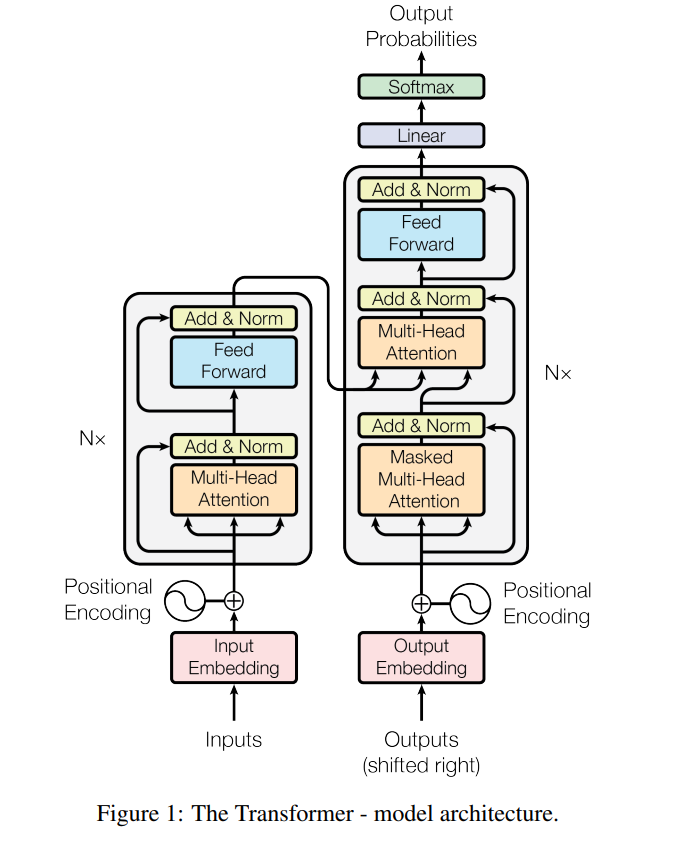

In [ ]:
# Now we will implement the feed forward network which is a MLP

In [ ]:
class FeedForward(nn.Module):
  """ a simple linear layer followed by a non-linearity """

  def __init__(self,n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd,n_embd),
        nn.ReLU(),
    )

  def forward(self,x):
    return self.net(x)


# The Main reason we are adding the ffd after the Self Attention is, the tokens/nodes looked at each other but we are immediately calculating
# the logits, they don't have enough time to think on and make sense on what they found from the other tokens. By adding this each individual
# token will think or make sense of the data it got from the self attention.


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
n_embd = 32
block_size=8

class BigramLanguageModel(nn.Module):

  def __init__ (self): # vocab_size is already defined
    super().__init__()

    self.token_embedding_table = nn.Embedding(vocab_size,n_embd) # changing from vocab_size to n_embd because we are now getting the logits
    # directly but to expand it to pass through the intermediate stage, adding or specifying the number of dimmensions.
    # this wont gives logits but gives us token embedings to get the logits we need to add a linear layer
    self.lm_head = nn.Linear(n_embd, vocab_size) #  --> linear layer

    # Another thing is what people do is not only embed the input tokens but also their postions.
    self.position_embedding_table = nn.Embedding(block_size,n_embd) # block_size because the inputs will of that size only
    # self.sa_head = Head(n_embd)
    self.sa_heads = MultiHeadAttention(4,n_embd//4) # 4 heads of 8-dimensional self attention
    self.ffwd = FeedForward(n_embd)



  def forward(self, idx ,targets=None):

    B,T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    token_emb = self.token_embedding_table(idx) # now we wont be getting logists anymore here -> (B,T,n_embd)
    pos_emb = self.position_embedding_table(torch.arange(T)) # (T,n_embd)
    x = token_emb + pos_emb # (B,T,n_embd) + (T,n_embd) work fine because of broadcasting
    x = self.sa_heads(x) # applying one head of self attention (B,T,n_embd)
    x = self.ffwd(x) # (B,T,n_embd)

    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets == None :
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits,targets)
    return logits,loss

  def generate(self,idx,max_new_tokens):
    for _ in range(max_new_tokens):
      # get the predictions
      idx_cond = idx[:,-block_size:]
      logits, loss = self(idx_cond)
      logits = logits[:,-1, :]
      probs = F.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,idx_next),dim=1)
    return idx

m = BigramLanguageModel()
logits,loss = m(xb,yb)
print(logits.shape)
print(loss)

idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx,max_new_tokens=100)[0].tolist()))

torch.Size([256, 65])
tensor(4.2610, grad_fn=<NllLossBackward0>)

k&RxYXjp
VBWlJ:-3mf-M heHWb Hlsq&ZdojOugDN'!AlA?AvwQC&UFdExeo!Fl3jCUXbeCRn:.;nTr;oWNgyRHIBylUTGK3apO


In [ ]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

max_iters = 10000
batch_size = 32
eval_interval = 500

for iter in range(max_iters):


  # every once in a while evaluate the loss on train and val sets
  if iter % eval_interval == 0 :
    losses = estimate_loss()
    print(f'step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}')

  # sample a batch of data
  xb,yb = get_batch("train")

  # evaluate the loss
  logits, loss = m(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

# print(loss.item())


step 0: train loss 4.2491, val loss 4.2484
step 500: train loss 2.6170, val loss 2.6302
step 1000: train loss 2.4841, val loss 2.4700
step 1500: train loss 2.3975, val loss 2.4016
step 2000: train loss 2.3504, val loss 2.3656
step 2500: train loss 2.3147, val loss 2.3229
step 3000: train loss 2.2775, val loss 2.3068
step 3500: train loss 2.2695, val loss 2.2871
step 4000: train loss 2.2538, val loss 2.2632
step 4500: train loss 2.2286, val loss 2.2506
step 5000: train loss 2.2178, val loss 2.2422
step 5500: train loss 2.2074, val loss 2.2243
step 6000: train loss 2.1828, val loss 2.2105
step 6500: train loss 2.1863, val loss 2.2110
step 7000: train loss 2.1741, val loss 2.2218
step 7500: train loss 2.1789, val loss 2.1943
step 8000: train loss 2.1571, val loss 2.1948
step 8500: train loss 2.1589, val loss 2.1945
step 9000: train loss 2.1423, val loss 2.1925
step 9500: train loss 2.1396, val loss 2.1931


In [ ]:
estimate_loss()
# we have gone from 2.2 to 2.1 of validation loss, the output is not that great, but the loss is improving.

{'train': tensor(2.1336), 'val': tensor(2.1790)}

In [ ]:
idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx,max_new_tokens=100)[0].tolist()))


ISLINIO:
I thim no my a in
That enater:
Ences,
OLBUCENTET:
And kime durn,
Beignive,
In'le vikeelie, 


In [ ]:
# Now we are going to start intersperse (mixing up of) of communication with computation by implementing the block.
# That's what the transformer does when it has blocks that communicate and compute and it groups them and replicates them (refer img abv)
# The bock is the rectangular border in the image on the right, we are not implementing the cross attention which is the left one.


In [ ]:
class Block(nn.Module):
  """ Transformer block : communication followed by computation """
  def __init__(self,n_embd,n_head):
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head,head_size)
    self.ffwd = FeedForward(n_embd)

  def forward(self,x):
    x = self.sa(x)
    x = self.ffwd(x)
    return x


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
n_embd = 32
block_size=8

class BigramLanguageModel(nn.Module):

  def __init__ (self): # vocab_size is already defined
    super().__init__()

    self.token_embedding_table = nn.Embedding(vocab_size,n_embd) # changing from vocab_size to n_embd because we are now getting the logits
    # directly but to expand it to pass through the intermediate stage, adding or specifying the number of dimmensions.
    # this wont gives logits but gives us token embedings to get the logits we need to add a linear layer
    self.lm_head = nn.Linear(n_embd, vocab_size) #  --> linear layer

    # Another thing is what people do is not only embed the input tokens but also their postions.
    self.position_embedding_table = nn.Embedding(block_size,n_embd) # block_size because the inputs will of that size only

    self.blocks = nn.Sequential(
        Block(n_embd,n_head=4),
        Block(n_embd,n_head=4),
        Block(n_embd,n_head=4),
    )



  def forward(self, idx ,targets=None):

    B,T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    token_emb = self.token_embedding_table(idx) # now we wont be getting logists anymore here -> (B,T,n_embd)
    pos_emb = self.position_embedding_table(torch.arange(T)) # (T,n_embd)
    x = token_emb + pos_emb # (B,T,n_embd) + (T,n_embd) work fine because of broadcasting
    x = self.blocks(x) # (B,T,n_embd)

    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets == None :
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits,targets)
    return logits,loss

  def generate(self,idx,max_new_tokens):
    for _ in range(max_new_tokens):
      # get the predictions
      idx_cond = idx[:,-block_size:]
      logits, loss = self(idx_cond)
      logits = logits[:,-1, :]
      probs = F.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,idx_next),dim=1)
    return idx

m = BigramLanguageModel()
logits,loss = m(xb,yb)
print(logits.shape)
print(loss)

idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx,max_new_tokens=100)[0].tolist()))

torch.Size([256, 65])
tensor(4.2081, grad_fn=<NllLossBackward0>)

ccCm
$-ixXGbeiGAlXH!$fxnohnRE
mqcs,u'cK;UMSwJziSXniZmMeQGsWQBNbJ&R$j;bGMHyStdx?ho.Zuks V$Iu$d3QsXmg!


In [ ]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

max_iters = 10000
batch_size = 32
eval_interval = 500

for iter in range(max_iters):


  # every once in a while evaluate the loss on train and val sets
  if iter % eval_interval == 0 :
    losses = estimate_loss()
    print(f'step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}')

  # sample a batch of data
  xb,yb = get_batch("train")

  # evaluate the loss
  logits, loss = m(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

# print(loss.item())


step 0: train loss 4.2090, val loss 4.2079
step 500: train loss 3.0113, val loss 3.0093
step 1000: train loss 2.7081, val loss 2.7046
step 1500: train loss 2.5396, val loss 2.5315
step 2000: train loss 2.4796, val loss 2.4635
step 2500: train loss 2.4302, val loss 2.4219
step 3000: train loss 2.3982, val loss 2.3893
step 3500: train loss 2.3686, val loss 2.3557
step 4000: train loss 2.3480, val loss 2.3346
step 4500: train loss 2.3141, val loss 2.3221
step 5000: train loss 2.3054, val loss 2.3108
step 5500: train loss 2.2818, val loss 2.3022
step 6000: train loss 2.2452, val loss 2.2769
step 6500: train loss 2.2491, val loss 2.2788
step 7000: train loss 2.2278, val loss 2.2437
step 7500: train loss 2.2190, val loss 2.2368
step 8000: train loss 2.1952, val loss 2.2280
step 8500: train loss 2.1884, val loss 2.2258
step 9000: train loss 2.1777, val loss 2.2133
step 9500: train loss 2.1816, val loss 2.2008


In [ ]:
# As we can see that the validation loss is not improved, the reason for that is we are now starting to get a deep neural net.
# Deep neural nets suffer from optimization issues, that maybe the reason.

# There are 2 optimizations that help with the depth of these networks and make sure the network is optimizable.
# 1) skip conections/ residual connections
# If we look at the image of the Transformer above, we can notice arrows pointing to the "Add & Norm".
# The concept here is we transform the data through the net, but we will have a skip connection with an addition from the previous features


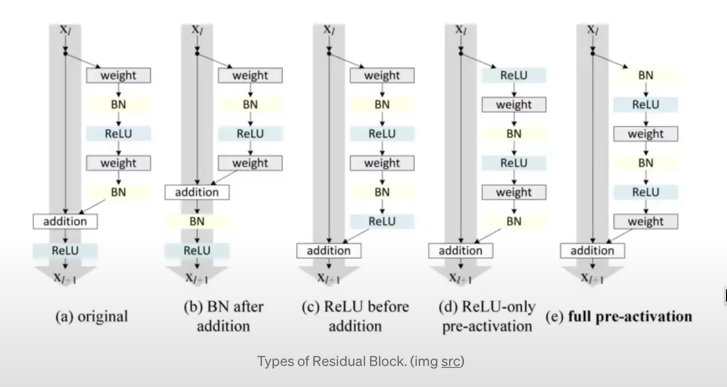

In [ ]:
# As we see in the above images, we fork off from the residual path way and perform some computation and project back to the
# residual pathway via addition, we go from the inputs to the targets only via addition.
# The reason this is useful is, if we remember the micrograd we know that during back-propagation, the addition distributes gradients
# equally to both of its branches that are the inputs, so now the gradients from the loss goes to every addition node (if there are many)
# and goes to the input and also fork off into the computational blocks on the side, basically we have this gradients super highway, that
# goes directly from the tragets all the way to the input.
# These residual blocks are usually initialized in the begining so they contribute very very little or nothing to the
# residual pathway(the highway), in the begining they are almost like they are not there at all because their contribution is neglible.
# But during the optimization, the slowly start contributing overtime. This helps with the optimization.

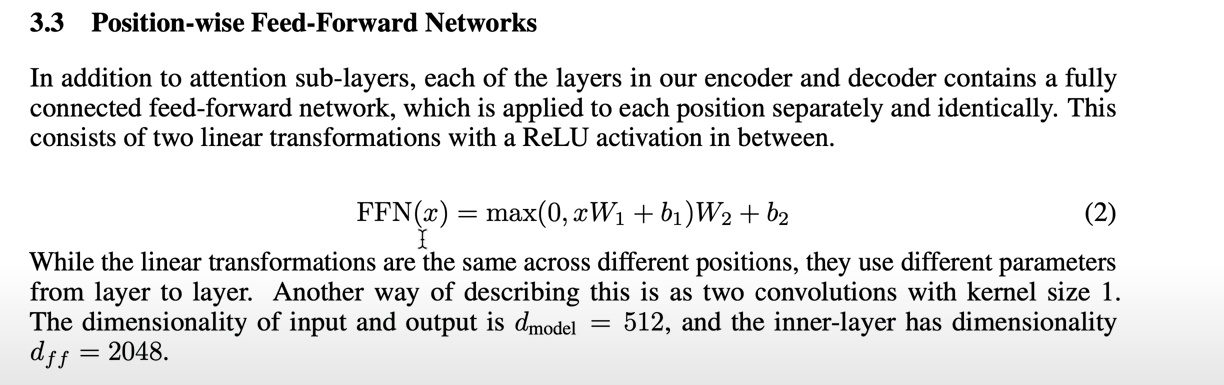

In [ ]:
# From the paper, we are expanding the representation of feed forward network(512 → 2048) to allow richer combinations of features
# and again compressing it back (2048 -> 514) multiplied by 4.

In [ ]:
class MultiHeadAttention(nn.Module):
  """ Multiple heads of self-attention in parallel """

  def __init__(self, num_heads,head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd,n_embd) # creating a projection

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.proj(out) # applying the projection back to the residual pathway
    return out

class FeedForward(nn.Module):
  """ a simple linear layer followed by a non-linearity """

  def __init__(self,n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd,4 * n_embd), # expanding to allow richer combinations of features
        nn.ReLU(),
        nn.Linear(4 * n_embd,n_embd) # the projection layer for the feedward net projecting back to the residual pathway and also it is compressed
    )

  def forward(self,x):
    return self.net(x)


class Block(nn.Module):
  """ Transformer block : communication followed by computation """
  def __init__(self,n_embd,n_head):
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head,head_size)
    self.ffwd = FeedForward(n_embd)

  def forward(self,x):
    x = x + self.sa(x)     # branching off => residual pathway + residual branch
    x = x + self.ffwd(x)   # branching off => residual pathway + residual branch
    return x


class BigramLanguageModel(nn.Module):

  def __init__ (self):
    super().__init__()

    self.token_embedding_table = nn.Embedding(vocab_size,n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size) #  --> linear layer

    self.position_embedding_table = nn.Embedding(block_size,n_embd) # block_size because the inputs will of that size only

    self.blocks = nn.Sequential(
        Block(n_embd,n_head=4),
        Block(n_embd,n_head=4),
        Block(n_embd,n_head=4),
    )


  def forward(self, idx ,targets=None):

    B,T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    token_emb = self.token_embedding_table(idx) # now we wont be getting logists anymore here -> (B,T,n_embd)
    pos_emb = self.position_embedding_table(torch.arange(T)) # (T,n_embd)
    x = token_emb + pos_emb # (B,T,n_embd) + (T,n_embd) work fine because of broadcasting
    x = self.blocks(x) # (B,T,n_embd)

    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets == None :
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits,targets)
    return logits,loss

  def generate(self,idx,max_new_tokens):
    for _ in range(max_new_tokens):
      # get the predictions
      idx_cond = idx[:,-block_size:]
      logits, loss = self(idx_cond)
      logits = logits[:,-1, :]
      probs = F.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,idx_next),dim=1)
    return idx

m = BigramLanguageModel()
logits,loss = m(xb,yb)
print(logits.shape)
print(loss)


torch.Size([256, 65])
tensor(4.4457, grad_fn=<NllLossBackward0>)


In [ ]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

max_iters = 10000
batch_size = 32
eval_interval = 500

for iter in range(max_iters):


  # every once in a while evaluate the loss on train and val sets
  if iter % eval_interval == 0 :
    losses = estimate_loss()
    print(f'step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}')

  # sample a batch of data
  xb,yb = get_batch("train")

  # evaluate the loss
  logits, loss = m(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

# print(loss.item())


step 0: train loss 4.4573, val loss 4.4648
step 500: train loss 2.3861, val loss 2.4141
step 1000: train loss 2.2433, val loss 2.2627
step 1500: train loss 2.1764, val loss 2.2122
step 2000: train loss 2.1195, val loss 2.1737
step 2500: train loss 2.0841, val loss 2.1479
step 3000: train loss 2.0582, val loss 2.1314
step 3500: train loss 2.0274, val loss 2.1094
step 4000: train loss 2.0086, val loss 2.0944
step 4500: train loss 1.9877, val loss 2.0941
step 5000: train loss 1.9844, val loss 2.0918
step 5500: train loss 1.9727, val loss 2.0633
step 6000: train loss 1.9596, val loss 2.0667
step 6500: train loss 1.9448, val loss 2.0592
step 7000: train loss 1.9417, val loss 2.0356
step 7500: train loss 1.9303, val loss 2.0574
step 8000: train loss 1.9130, val loss 2.0493
step 8500: train loss 1.9178, val loss 2.0164
step 9000: train loss 1.9175, val loss 2.0295
step 9500: train loss 1.9034, val loss 2.0325


In [ ]:
estimate_loss()
# we have gone from 2.1 to 2.0 of validation loss.

{'train': tensor(1.9016), 'val': tensor(2.0163)}

In [ ]:
idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx,max_new_tokens=100)[0].tolist()))


My liffectue,
Nay, mesty stred strane:
Cither verniand noth thy drainged ever in so spilina?
Wardler


In [ ]:
# 2) The second optimization is the Norm in the image with "Add & Norm", the add refers to the residual. The Norm in this case is the
# layer Norm.

# we take the batchnorm implemented previously

In [ ]:
class BatchNorm1d:

  def __init__(self, dim,eps=1e-5,momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__ (self,x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2 :
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else :
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]

torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32,100)
x = module(x)
x.shape

torch.Size([32, 100])

In [ ]:
x[:,0].mean(), x[:,0].std() # we can see that after normlization the mean is 0 and std is 1 across the columns with row dim becoming 1

(tensor(7.4506e-09), tensor(1.0000))

In [ ]:
x[0:,].mean(), x[0:,].std() # but mean of single input from a batch (a row) is not normalized

(tensor(-2.6822e-09), tensor(0.9844))

In [ ]:
# Now implementing the layer norm, basically instead of taking the mean across the columns, we take it across the rows making the col dim
# 1 and we don't need any buffers too, because we are not doing it across the batches.

class LayerNorm1d:

  def __init__(self, dim,eps=1e-5,momentum=0.1):
    self.eps = eps
    # parameters trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__ (self,x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # input features mean
    xvar = x.var(1, keepdim=True) # input features variance
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32,100)
x = module(x)
x.shape


torch.Size([32, 100])

In [ ]:
x[:,0].mean(), x[:,0].std()

(tensor(0.1469), tensor(0.8803))

In [ ]:
x[0,:].mean(),x[0,:].std()

(tensor(-9.5367e-09), tensor(1.0000))

In [ ]:
# There is a slight deviation here from the original paper that is if we see in the image of the transformere above, the 'Add & Norm' are
# happening after the transformation but now-a-days it is more common to apply the Layer now before the transformation. It is called
# pre-norm forumulation.

In [ ]:
class MultiHeadAttention(nn.Module):
  """ Multiple heads of self-attention in parallel """

  def __init__(self, num_heads,head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd,n_embd) # creating a projection

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.proj(out)
    return out

class FeedForward(nn.Module):
  """ a simple linear layer followed by a non-linearity """

  def __init__(self,n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd,4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd,n_embd)
    )

  def forward(self,x):
    return self.net(x)


class Block(nn.Module):
  """ Transformer block : communication followed by computation """
  def __init__(self,n_embd,n_head):
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head,head_size)
    self.ffwd = FeedForward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd) # one for self attention
    self.ln2 = nn.LayerNorm(n_embd) # one for feed forward net

  def forward(self,x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x


class BigramLanguageModel(nn.Module):

  def __init__ (self):
    super().__init__()

    self.token_embedding_table = nn.Embedding(vocab_size,n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)

    self.position_embedding_table = nn.Embedding(block_size,n_embd) # block_size because the inputs will of that size only

    self.blocks = nn.Sequential(
        Block(n_embd,n_head=4),
        Block(n_embd,n_head=4),
        Block(n_embd,n_head=4),
        nn.LayerNorm(n_embd)    # one layer norm at the end of the attention blocks
    )


  def forward(self, idx ,targets=None):

    B,T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    token_emb = self.token_embedding_table(idx) # now we wont be getting logists anymore here -> (B,T,n_embd)
    pos_emb = self.position_embedding_table(torch.arange(T)) # (T,n_embd)
    x = token_emb + pos_emb # (B,T,n_embd) + (T,n_embd) work fine because of broadcasting
    x = self.blocks(x) # (B,T,n_embd)

    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets == None :
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits,targets)
    return logits,loss

  def generate(self,idx,max_new_tokens):
    for _ in range(max_new_tokens):
      # get the predictions
      idx_cond = idx[:,-block_size:]
      logits, loss = self(idx_cond)
      logits = logits[:,-1, :]
      probs = F.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,idx_next),dim=1)
    return idx

m = BigramLanguageModel()
logits,loss = m(xb,yb)
print(logits.shape)
print(loss)


torch.Size([256, 65])
tensor(4.2576, grad_fn=<NllLossBackward0>)


In [ ]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

max_iters = 10000
batch_size = 32
eval_interval = 500

for iter in range(max_iters):


  # every once in a while evaluate the loss on train and val sets
  if iter % eval_interval == 0 :
    losses = estimate_loss()
    print(f'step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}')

  # sample a batch of data
  xb,yb = get_batch("train")

  # evaluate the loss
  logits, loss = m(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

# print(loss.item())


step 0: train loss 4.2474, val loss 4.2444
step 500: train loss 2.4055, val loss 2.3924
step 1000: train loss 2.2648, val loss 2.2681
step 1500: train loss 2.1675, val loss 2.1945
step 2000: train loss 2.1350, val loss 2.1620
step 2500: train loss 2.0874, val loss 2.1501
step 3000: train loss 2.0703, val loss 2.1309
step 3500: train loss 2.0579, val loss 2.1033
step 4000: train loss 2.0234, val loss 2.0969
step 4500: train loss 2.0145, val loss 2.1003
step 5000: train loss 2.0021, val loss 2.0881
step 5500: train loss 1.9737, val loss 2.0741
step 6000: train loss 1.9547, val loss 2.0521
step 6500: train loss 1.9394, val loss 2.0578
step 7000: train loss 1.9496, val loss 2.0379
step 7500: train loss 1.9421, val loss 2.0393
step 8000: train loss 1.9236, val loss 2.0129
step 8500: train loss 1.9122, val loss 2.0244
step 9000: train loss 1.9220, val loss 2.0335
step 9500: train loss 1.9021, val loss 2.0359


In [ ]:
estimate_loss()
# there is no significant improvement, but if our network was big, it would have helped us.

{'train': tensor(1.9077), 'val': tensor(2.0133)}

In [ ]:
idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx,max_new_tokens=100)[0].tolist()))



ISARELLO:
And him
onour cannot thou hould words this wicking of us of thee when sy purts news
In mi


In [ ]:
# Refactoring the code little bit
n_head = 6
n_layer = 6
n_embd = 384
dropout = 0.2  # 20% of the calculations are set to 0
learning_rate = 3e-4
block_size = 256
batch_size = 64
max_iters = 10000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_interval = 500
eval_iters = 200


# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


class Head(nn.Module):
  """ one head of self attention """

  def __init__ (self,head_size):
    super().__init__()
    self.key = nn.Linear(n_embd,head_size,bias=False)
    self.query = nn.Linear(n_embd,head_size,bias=False)
    self.value = nn.Linear(n_embd,head_size,bias=False)
    self.register_buffer("tril",torch.tril(torch.ones(block_size, block_size)))
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    k = self.key(x) # B,T,C
    q = self.query(x) # B,T,C
    # compute attention scores (affinitiess)
    wei = q  @ k.transpose(-2,-1) * (C**-0.5)  # B,T,C @ B,T,C => B,T,T
    wei = wei.masked_fill(self.tril[:T,:T] ==0, float('-inf')) # B,T,T
    wei = F.softmax(wei, dim=-1) # B,T,T
    wei = self.dropout(wei) #  ------------------> adding drop out
    # perform the weighted aggregation of the vallues
    v = self.value(x) # B,T,C
    out = wei @ v # (B,T,T) @ (B,T,C) = (B,T,T)
    return out

class MultiHeadAttention(nn.Module):
  """ Multiple heads of self-attention in parallel """

  def __init__(self, num_heads,head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd,n_embd) # creating a projection
    self.dropout = nn.Dropout(dropout)  # ---------->   adding dropout

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out

class FeedForward(nn.Module):
  """ a simple linear layer followed by a non-linearity """

  def __init__(self,n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd,4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd,n_embd), # projection layer back to the residual pathway
        nn.Dropout(dropout) #  ------> Dropout is something we add right before the residual branch projects back to the residual pathway.
        # Dropout’s purpose is to randomly zero out some activations during training to prevent overfitting. we are scaling up the model
        # so to avoid the overffitting we are addding this dropout.
    )

  def forward(self,x):
    return self.net(x)


class Block(nn.Module):
  """ Transformer block : communication followed by computation """
  def __init__(self,n_embd,n_head):
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head,head_size)
    self.ffwd = FeedForward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd) # one for self attention
    self.ln2 = nn.LayerNorm(n_embd) # one for feed forward net

  def forward(self,x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x


class BigramLanguageModel(nn.Module):

  def __init__ (self):
    super().__init__()

    self.token_embedding_table = nn.Embedding(vocab_size,n_embd)
    self.position_embedding_table = nn.Embedding(block_size,n_embd)
    self.blocks = nn.Sequential(*[Block(n_embd,n_head=n_head) for _ in range(n_layer)])
    self.ln_f = nn.LayerNorm(n_embd) # final layer norm
    self.lm_head = nn.Linear(n_embd, vocab_size)


  def forward(self, idx ,targets=None):

    B,T = idx.shape
    idx = idx.to(device) # Move idx to the same device as the model parameters

    # idx and targets are both (B,T) tensor of integers
    token_emb = self.token_embedding_table(idx) # now we wont be getting logists anymore here -> (B,T,n_embd)
    pos_emb = self.position_embedding_table(torch.arange(T).to(device)) # (T,n_embd) # Move position embedding also
    x = token_emb + pos_emb # (B,T,n_embd) + (T,n_embd) work fine because of broadcasting
    x = self.blocks(x)  # (B,T,n_embd)
    x = self.ln_f(x) # apply the final layer norm

    logits = self.lm_head(x) # (B,T,vocab_size)


    if targets is not None :
      targets = targets.to(device)
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits,targets)
    else:
      loss = None
    return logits,loss

  def generate(self,idx,max_new_tokens):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):
        # crop idx to the last block_size tokens
        idx_cond = idx[:, -block_size:].to(device) # Move idx_cond to the same device as the model parameters
        # get the predictions
        logits, loss = self(idx_cond)
        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B, C)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1) # (B, C)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
        # append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

model = BigramLanguageModel()
m = model.to(device)

logits,loss = model(xb,yb)
print(logits.shape)
print(loss)

torch.Size([256, 65])
tensor(4.3673, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 10788929


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), learning_rate)

for iter in range(max_iters):

  # every once in a while evaluate the loss on train and val sets
  if iter % eval_interval == 0 :
    losses = estimate_loss()
    print(f'step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}')

  # sample a batch of data
  xb,yb = get_batch("train")

  # evaluate the loss
  logits, loss = model(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

# print(loss.item())


step 0: train loss 4.4015, val loss 4.3953
step 500: train loss 2.0170, val loss 2.0876
step 1000: train loss 1.6157, val loss 1.7884
step 1500: train loss 1.4378, val loss 1.6436
step 2000: train loss 1.3414, val loss 1.5648
step 2500: train loss 1.2783, val loss 1.5261
step 3000: train loss 1.2243, val loss 1.5018
step 3500: train loss 1.1813, val loss 1.4848
step 4000: train loss 1.1398, val loss 1.4846
step 4500: train loss 1.1024, val loss 1.4805
step 5000: train loss 1.0720, val loss 1.4829


KeyboardInterrupt: 

In [ ]:
estimate_loss()
# As we can see there is significant improvement in the validation loss even thoug we ran it only 5000 steps

{'train': tensor(1.0377), 'val': tensor(1.4957)}

In [ ]:
idx = torch.zeros((1,1), dtype=torch.long)
print(decode(model.generate(idx.to(device),max_new_tokens=100)[0].tolist()))


Edward Oxford, he hath some placed within his
rest! When our committed serviscation,
and all the eve


In [ ]:
# we cannot run this on the collab, its way big for it.

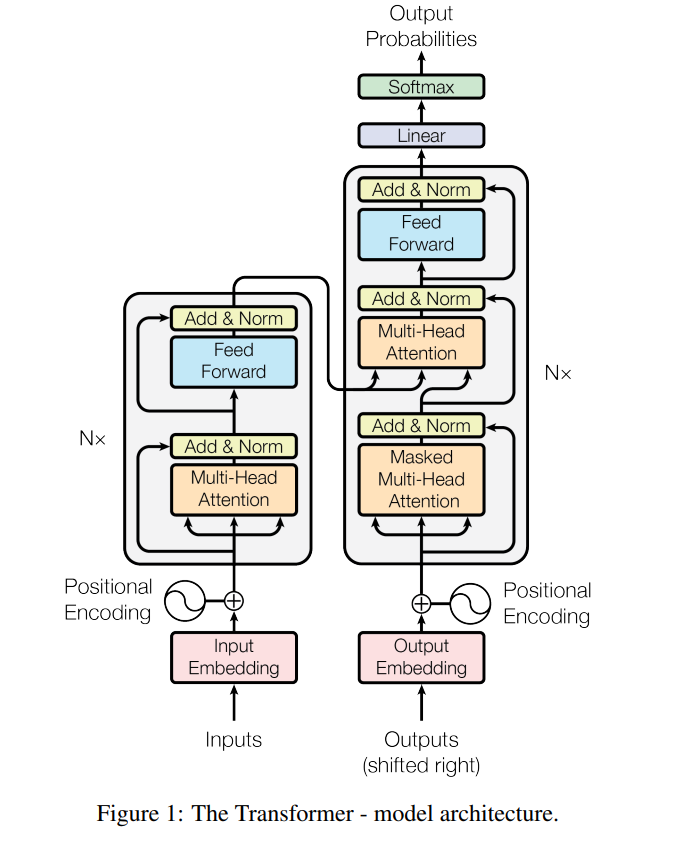

In [ ]:
# What we implemented here is a decoder only transformer, the left part in the above image which is enocoder is not there and there is no
# cross attention block, we only have self attention block.

# The reason why we are Decoder only is because we are only generating the text. What makes it a decoder is that we are using a traingular
# mask in our transformer, it has this autoregressive property where we can just go and sample from it.

# The Encoder is used when we have some additional information and want to generate something according to it like Language translation
# ex : Telugu to English, the encoder takes in the Telugu sentence and tokens are created from it, but here there won't be any
# traingular masking which we did in the decoder.
# Now the outputs of the decoder are brought in through the 'cross attention' to the decoder. So the queries are still generated from the x
# but the keys and the values are coming from the side.

# Note : A better version of this implementation will be in Andrej Karpathy's git repo